In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
os.chdir('../')
from eval_helpers import calculate_recall_score, plot_recall_by_k, recall
from candidate_generation import *
os.chdir('../../data/')

In [2]:
transactions = pd.read_pickle('../data/compressed_data/transactions_train.pkl')
customers = pd.read_pickle('../data/compressed_data/customers.pkl')
articles = pd.read_pickle('../data/compressed_data/articles.pkl')

transactions['week'] = 104 - (transactions.t_dat.max() - transactions.t_dat).dt.days // 7

print('First week num: ', transactions.week.min(), '\nLast week num: ', transactions.week.max(), '\n')

# Test week is week after last week in train data
test_week = transactions.week.max()
train_weeks = range(test_week - 10, test_week)

# Filter transactions to last 10 weeks (most recent data)
transactions_train = transactions[transactions.week.isin(train_weeks)]
transaction_test = transactions[transactions.week == test_week]

First week num:  0 
Last week num:  104 



# Quick preprocess customers

In [3]:
def age_groups(age):
    if age < 20:
        return '0-20'
    elif age < 25:
        return '20-24'
    elif age < 30:
        return '25-29'
    elif age < 40:
        return '30-39'
    elif age < 60:
        return '40-59'
    else:
        return '60+'

In [4]:
# Check best channel for each customer
cust_sales_channel = transactions_train.groupby('customer_id')['sales_channel_id'].value_counts()\
    .groupby('customer_id').head(1).reset_index().drop('count', axis=1)

In [5]:
customers.drop(columns=['FN', 'Active'], inplace=True)

customers['age'] = customers['age'].fillna(customers['age'].mean())
customers['age_group'] = customers['age'].apply(age_groups)

mapping_club_member_status = {'ACTIVE': 1, 'PRE-CREATE': 0, np.NaN: 0, 'LEFT CLUB': 0}
mapping_fashion_news = {'NONE':0, 'Regularly':1, np.NaN: 0, 'Monthly':1}

customers['club_member_status'] = customers['club_member_status'].apply(lambda x: mapping_club_member_status[x])
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].apply(lambda x: mapping_fashion_news[x])

customers.fillna(0, inplace=True)

customers = pd.merge(customers, cust_sales_channel, on='customer_id', how='left')

customers.fillna(2, inplace=True) # 2 is online channel (most popular)

/Users/jniedziela/.pyenv/versions/3.9/envs/AIPRO/lib/python3.11/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/jniedziela/.pyenv/versions/3.9/envs/AIPRO/lib/python3.11/site-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in half_scalars
  the_mean = the_sum / count if count > 0 else np.nan


# Prepare Test for comparison

In [6]:
test_baskets = transaction_test.groupby('customer_id')['article_id']\
    .apply(set)\
    .reset_index()\
    .rename(columns={'article_id': 'true_purchase'})
test_baskets.head()

,customer_id,true_purchase
0,80,{624486001}
1,86,{827487003}
2,107,"{757926001, 640021019, 788575004}"
3,117,{874110016}
4,179,"{158340001, 935892001, 799365027, 918171001, 9..."


# Compare seasonal bestsellers

In [7]:
seasonal_bestsellers = pd.read_csv('candidates_200_ranks/seasonal_candidates_2019.csv')
seasonal_basket = set(seasonal_bestsellers.article_id.unique())

In [8]:
seasonal_analysis = test_baskets.copy()

seasonal_analysis['recall'] = seasonal_analysis.apply(lambda x: recall(x['true_purchase'], seasonal_basket), axis=1)
seasonal_analysis['num_purchased'] = seasonal_analysis['true_purchase'].apply(len)

seasonal_analysis.drop('true_purchase', axis=1, inplace=True)
seasonal_analysis = pd.merge(seasonal_analysis, customers, on='customer_id', how='left')

seasonal_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68984 entries, 0 to 68983
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             68984 non-null  int32  
 1   recall                  68984 non-null  float64
 2   num_purchased           68984 non-null  int64  
 3   club_member_status      68984 non-null  float64
 4   fashion_news_frequency  68984 non-null  float64
 5   age                     68984 non-null  float16
 6   postal_code             68984 non-null  int32  
 7   age_group               68984 non-null  object 
 8   sales_channel_id        68984 non-null  float64
dtypes: float16(1), float64(4), int32(2), int64(1), object(1)
memory usage: 3.8+ MB


In [63]:
seasonal_analysis.drop(columns=['customer_id', 'age_group']).corr().loc['recall']

recall                    1.000000
num_purchased            -0.011542
club_member_status       -0.001457
fashion_news_frequency   -0.003369
age                      -0.023138
postal_code               0.001930
sales_channel_id         -0.007229
Name: recall, dtype: float64

In [62]:
seasonal_analysis[seasonal_analysis.recall > 0].drop(columns=['customer_id', 'age_group']).corr().loc['recall']

recall                    1.000000
num_purchased            -0.636077
club_member_status       -0.011849
fashion_news_frequency    0.030283
age                      -0.000961
postal_code               0.009324
sales_channel_id         -0.107618
Name: recall, dtype: float64

<Axes: xlabel='sales_channel_id', ylabel='recall'>

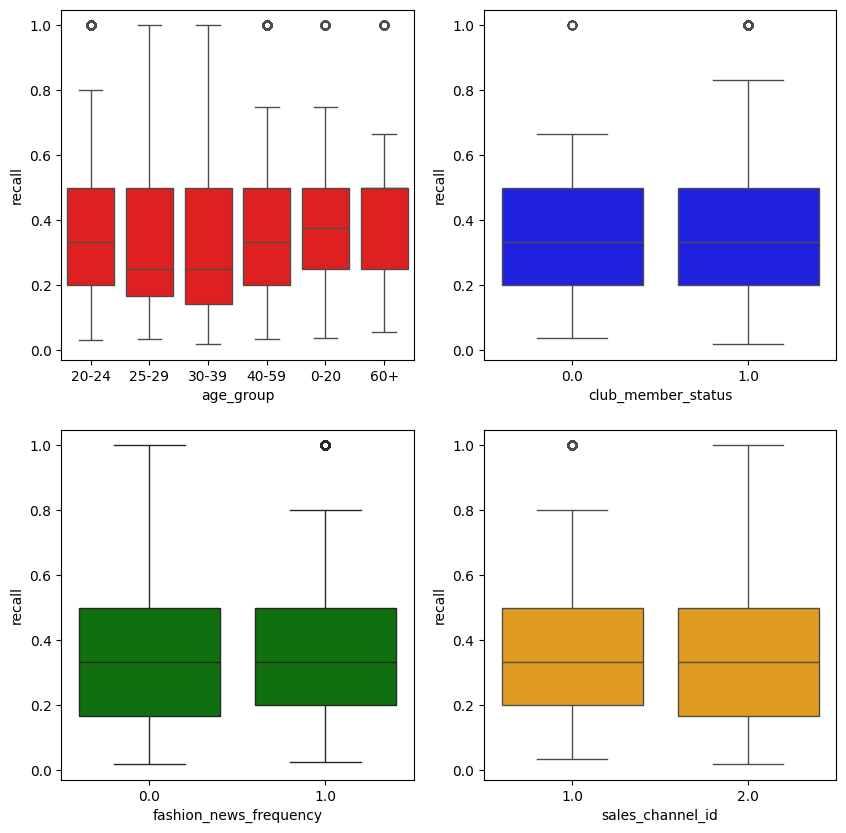

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

sns.boxplot(data=seasonal_analysis[seasonal_analysis.recall > 0], y='recall', x='age_group', ax=ax[0][0], color='red')

sns.boxplot(data=seasonal_analysis[seasonal_analysis.recall > 0], y='recall', x='club_member_status', ax=ax[0][1], color='blue')

sns.boxplot(data=seasonal_analysis[seasonal_analysis.recall > 0], y='recall', x='fashion_news_frequency', ax=ax[1][0], color='green')

sns.boxplot(data=seasonal_analysis[seasonal_analysis.recall > 0], y='recall', x='sales_channel_id', ax=ax[1][1], color='orange')

# Similar not bought candidates analysis

In [16]:
sim_not_bought = pd.read_csv('candidates_200_ranks/sim_not_bought.csv')

In [17]:
top_200_snb_total = sim_not_bought[sim_not_bought.week != test_week][['customer_id', 'article_id', 'similarity_score']]\
    .sort_values('similarity_score', ascending=False)\
    .groupby('customer_id').head(200)

In [18]:
snb_basekts = top_200_snb_total.groupby('customer_id')['article_id']\
    .apply(set)\
    .reset_index()\
    .rename(columns={'article_id': 'snb_candidates'})
snb_basekts.head()

,customer_id,snb_candidates
0,0,"{784192001, 554901002, 820906002, 570367001, 8..."
1,1,"{727616001, 849984002, 842560003, 823189001, 6..."
2,2,"{748566023, 804992009, 914453002, 914453001, 7..."
3,4,"{917760001, 920448002, 878080001, 886720004, 8..."
4,6,"{761664001, 777728001, 761664003, 470636041, 7..."


In [56]:
snb_analysis = test_baskets.copy()

snb_analysis = pd.merge(snb_analysis, snb_basekts, on='customer_id', how='left')
snb_analysis['snb_candidates'] = [x if type(x) == set else set() for x in snb_analysis['snb_candidates']]

snb_analysis['recall'] = snb_analysis.apply(lambda x: recall(x['true_purchase'], x['snb_candidates']), axis=1)
snb_analysis['num_purchased'] = snb_analysis['true_purchase'].apply(len)

snb_analysis.drop(columns=['true_purchase', 'snb_candidates'], inplace=True)

snb_analysis = pd.merge(snb_analysis, customers, on='customer_id', how='left')

In [64]:
snb_analysis.drop(columns=['customer_id', 'age_group']).corr().loc['recall']

recall                    1.000000
num_purchased            -0.013879
club_member_status        0.013067
fashion_news_frequency    0.016250
age                       0.024204
postal_code               0.008653
sales_channel_id         -0.029140
Name: recall, dtype: float64

In [65]:
snb_analysis[snb_analysis.recall > 0].drop(columns=['customer_id', 'age_group']).corr().loc['recall']

recall                    1.000000
num_purchased            -0.648188
club_member_status        0.006189
fashion_news_frequency    0.005458
age                       0.061473
postal_code               0.027591
sales_channel_id         -0.107375
Name: recall, dtype: float64

<Axes: xlabel='sales_channel_id', ylabel='recall'>

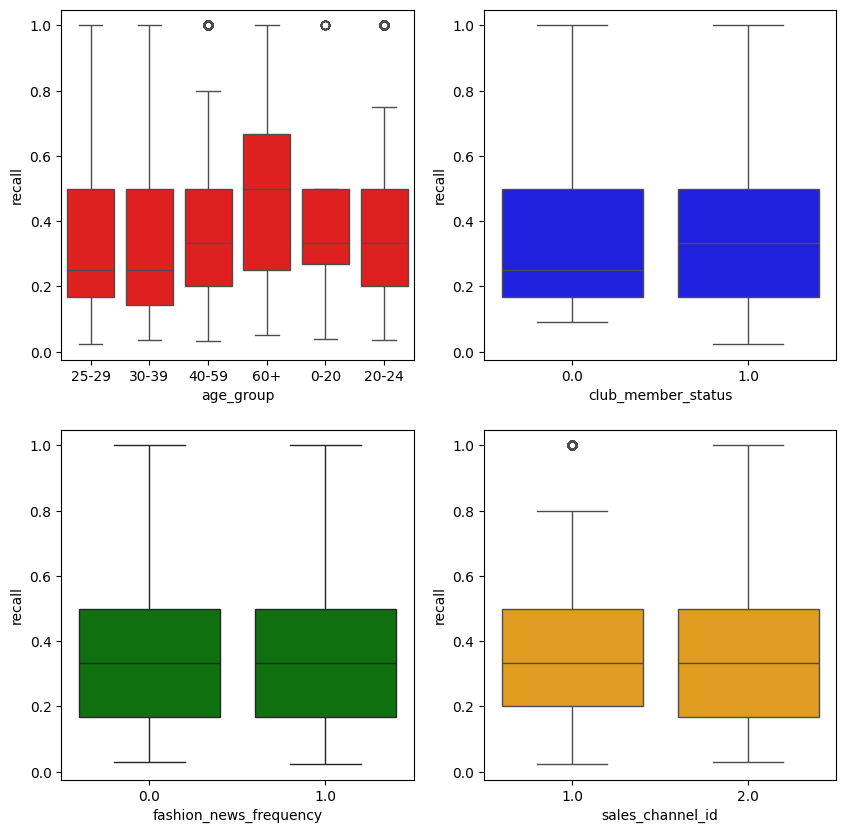

In [66]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

sns.boxplot(data=snb_analysis[snb_analysis.recall > 0], y='recall', x='age_group', ax=ax[0][0], color='red')

sns.boxplot(data=snb_analysis[snb_analysis.recall > 0], y='recall', x='club_member_status', ax=ax[0][1], color='blue')

sns.boxplot(data=snb_analysis[snb_analysis.recall > 0], y='recall', x='fashion_news_frequency', ax=ax[1][0], color='green')

sns.boxplot(data=snb_analysis[snb_analysis.recall > 0], y='recall', x='sales_channel_id', ax=ax[1][1], color='orange')

# Not interacted with candidates analysis

In [67]:
niw_candidates = pd.read_csv('candidates_200_ranks/niw_candidates_garment_group_name.csv')

In [78]:
niw_candidates_test = niw_candidates[niw_candidates.week == test_week - 1]

niw_baskets = niw_candidates_test.groupby('customer_id')['article_id']\
    .apply(set)\
    .reset_index()\
    .rename(columns={'article_id': 'niw_candidates'})

niw_baskets.head()

,customer_id,niw_candidates
0,2,"{820480001, 876416001, 858816001, 827968001, 8..."
1,6,"{820480001, 876416001, 858816001, 827968001, 8..."
2,38,"{820480001, 876416001, 858816001, 827968001, 8..."
3,86,"{820480001, 876416001, 858816001, 827968001, 8..."
4,90,"{820480001, 876416001, 858816001, 827968001, 8..."


In [80]:
niw_analysis = test_baskets.copy()

niw_analysis = pd.merge(niw_analysis, niw_baskets, on='customer_id', how='left')
niw_analysis['niw_candidates'] = [x if type(x) == set else set() for x in niw_analysis['niw_candidates']]

niw_analysis['recall'] = niw_analysis.apply(lambda x: recall(x['true_purchase'], x['niw_candidates']), axis=1)
niw_analysis['num_purchased'] = niw_analysis['true_purchase'].apply(len)

niw_analysis.drop(columns=['true_purchase', 'niw_candidates'], inplace=True)

niw_analysis = pd.merge(niw_analysis, customers, on='customer_id', how='left')

niw_analysis

,customer_id,recall,num_purchased,club_member_status,fashion_news_frequency,age,postal_code,age_group,sales_channel_id
0,80,0.000000,1,1.0,0.0,27.0,67,25-29,2.0
1,86,0.000000,1,1.0,1.0,33.0,73,30-39,2.0
2,107,0.000000,3,1.0,0.0,29.0,90,25-29,2.0
3,117,0.000000,1,1.0,1.0,25.0,98,25-29,2.0
4,179,0.142857,14,1.0,0.0,23.0,155,20-24,2.0
...,...,...,...,...,...,...,...,...,...
68979,1371868,0.000000,2,1.0,0.0,24.0,35764,20-24,2.0
68980,1371871,0.000000,2,1.0,0.0,50.0,71137,40-59,2.0
68981,1371879,0.100000,10,1.0,0.0,25.0,17978,25-29,2.0
68982,1371937,0.000000,2,1.0,1.0,45.0,43151,40-59,1.0


In [81]:
niw_analysis.drop(columns=['customer_id', 'age_group']).corr().loc['recall']

recall                    1.000000
num_purchased            -0.015186
club_member_status        0.011148
fashion_news_frequency    0.019658
age                      -0.001637
postal_code              -0.001010
sales_channel_id         -0.020883
Name: recall, dtype: float64

In [82]:
niw_analysis[niw_analysis.recall > 0].drop(columns=['customer_id', 'age_group']).corr().loc['recall']

recall                    1.000000
num_purchased            -0.650226
club_member_status        0.029984
fashion_news_frequency   -0.024724
age                       0.011993
postal_code               0.000194
sales_channel_id         -0.129911
Name: recall, dtype: float64

<Axes: xlabel='sales_channel_id', ylabel='recall'>

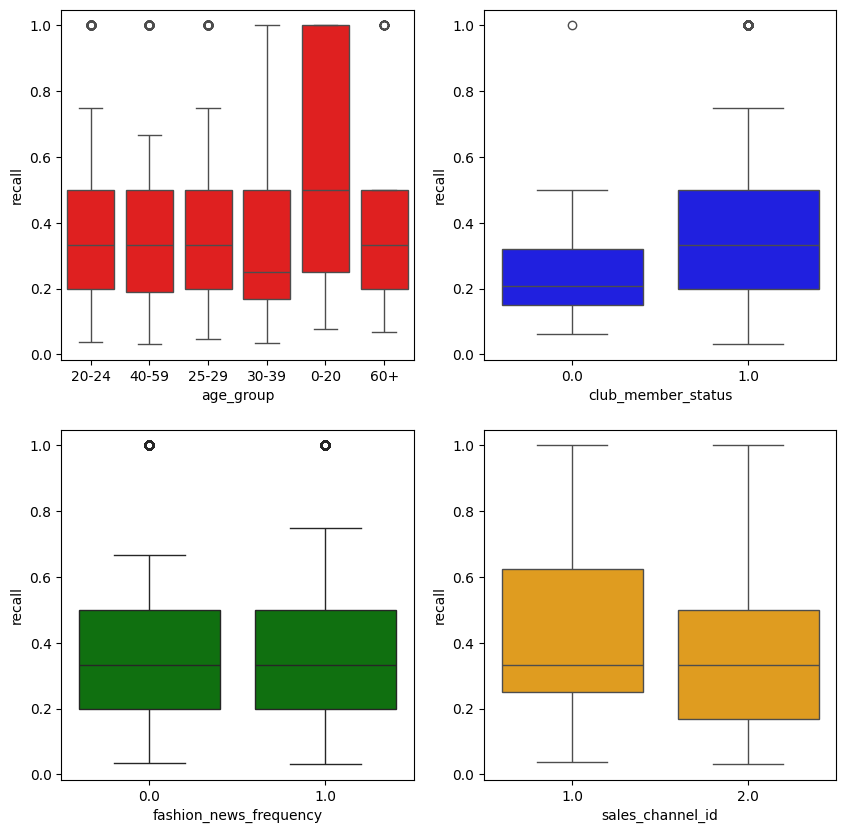

In [83]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

sns.boxplot(data=niw_analysis[niw_analysis.recall > 0], y='recall', x='age_group', ax=ax[0][0], color='red')

sns.boxplot(data=niw_analysis[niw_analysis.recall > 0], y='recall', x='club_member_status', ax=ax[0][1], color='blue')

sns.boxplot(data=niw_analysis[niw_analysis.recall > 0], y='recall', x='fashion_news_frequency', ax=ax[1][0], color='green')

sns.boxplot(data=niw_analysis[niw_analysis.recall > 0], y='recall', x='sales_channel_id', ax=ax[1][1], color='orange')